In [1]:
#     Exploratory Data Analysis of Skin Lesion Dataset
#     Copyright (C) 2024  Sebastián A. Cruz Romero

#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.

#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.

## Exploratory Data Analysis

### Import Libraries

In [2]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import torch
import cv2 as cv

### Utils

In [3]:
def get_image_paths(root_dir, extensions=['.jpg', '.png', '.jpeg']):
    """
    Get a list of all image file paths in the root_dir with specified extensions.
    
    Parameters:
    root_dir (str): Root directory to search for image files.
    extensions (list): List of file extensions to include.
    
    Returns:
    list: List of image file paths.
    """
    image_paths = []
    for ext in extensions:
        image_paths.extend(glob.glob(os.path.join(root_dir, '**', f'*{ext}'), recursive=True))
    return image_paths

def save_paths_to_csv(image_paths, csv_file):
    """
    Save image file paths to a CSV file using pandas.
    
    Parameters:
    image_paths (list): List of image file paths.
    csv_file (str): Path to the CSV file where paths will be saved.
    """
    df = pd.DataFrame(image_paths, columns=['Image Path'])
    df.to_csv(csv_file, index=False)

def plot_image_grid(df, image_column='image_path', class_column='class', grid_size=(10, 10), image_size=(300, 300)):
    """
    Plots a grid of images from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing image paths and their respective classes.
    image_column (str): Column name in the DataFrame that contains image paths.
    class_column (str): Column name in the DataFrame that contains image classes.
    grid_size (tuple): Size of the grid (rows, cols).
    image_size (tuple): Size to which each image will be resized (width, height).
    
    Returns:
    None
    """
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axes = axes.flatten()

    for i, (idx, row) in enumerate(df.iterrows()):
        if i >= grid_size[0] * grid_size[1]:
            break
        img_path = row[image_column]
        img_class = row[class_column]
        
        # Read and resize the image
        img = cv.imread(img_path)
        if img is None:
            print(f"Error loading image at {img_path}")
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, image_size)
        
        # Plot the image
        axes[i].imshow(img)
        axes[i].set_title(f"Type: {img_class}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def image_features(df, image_column='image_path'):
    """
    Adds image pixel values as features to the DataFrame and normalizes them.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing image paths.
    image_column (str): Column name in the DataFrame that contains image paths.
    
    Returns:
    pd.DataFrame: DataFrame with image pixel values added as new columns, normalized between 0 and 1.
    """
    # Initialize a list to hold the image pixel values
    image_features = []

    for idx, row in df.iterrows():
        img_path = row[image_column]
        
        # Read and resize the image
        img = cv.imread(img_path)
        if img is None:
            print(f"Error loading image at {img_path}")
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        # Normalize the image array
        img_normalized = img / 255.0
        
        # Flatten the normalized image array and add it to the list
        img_flattened = img_normalized.flatten()
        image_features.append(img_flattened)
    
    # Convert the list of image features to a DataFrame
    image_features_df = pd.DataFrame(image_features)
    df = pd.concat([df.reset_index(drop=True), image_features_df.reset_index(drop=True)], axis=1)
    
    return df 

### Fetching Melanoma Skin Cancer (Benign/Malignant) Image Paths

In [4]:
train_directory = '../data/melanoma_cancer_dataset/train'

# Get all image paths
train_benign_image_path = get_image_paths(train_directory+'/benign')
train_malignant_image_path = get_image_paths(train_directory+'/malignant')

# Save paths to CSV file
save_paths_to_csv(train_benign_image_path, "../data/image_paths/train_benign.csv")
save_paths_to_csv(train_malignant_image_path, "../data/image_paths/train_malignant.csv")

In [5]:
test_directory = '../data/melanoma_cancer_dataset/test'

# Get all image paths
test_benign_image_path = get_image_paths(test_directory+'/benign')
test_malignant_image_path = get_image_paths(test_directory+'/malignant')

# Save paths to CSV file
save_paths_to_csv(test_benign_image_path, "../data/image_paths/test_benign.csv")
save_paths_to_csv(test_malignant_image_path, "../data/image_paths/test_malignant.csv")

In [6]:
train_df_benign = pd.read_csv("../data/image_paths/train_benign.csv")
train_df_malignant = pd.read_csv("../data/image_paths/train_malignant.csv")

train_df_benign['Neoplasm Type'] = "Benign"
train_df_malignant['Neoplasm Type'] = "Malignant"

In [7]:
display(train_df_benign.head(), train_df_malignant.head())

,Image Path,Neoplasm Type
0,../data/melanoma_cancer_dataset/train/benign/m...,Benign
1,../data/melanoma_cancer_dataset/train/benign/m...,Benign
2,../data/melanoma_cancer_dataset/train/benign/m...,Benign
3,../data/melanoma_cancer_dataset/train/benign/m...,Benign
4,../data/melanoma_cancer_dataset/train/benign/m...,Benign


,Image Path,Neoplasm Type
0,../data/melanoma_cancer_dataset/train/malignan...,Malignant
1,../data/melanoma_cancer_dataset/train/malignan...,Malignant
2,../data/melanoma_cancer_dataset/train/malignan...,Malignant
3,../data/melanoma_cancer_dataset/train/malignan...,Malignant
4,../data/melanoma_cancer_dataset/train/malignan...,Malignant


In [8]:
test_df_benign = pd.read_csv("../data/image_paths/test_benign.csv")
test_df_malignant = pd.read_csv("../data/image_paths/test_malignant.csv")

test_df_benign['Neoplasm Type'] = "Benign"
test_df_malignant['Neoplasm Type'] = "Malignant"

In [9]:
display(test_df_benign.head(), test_df_malignant.head())

,Image Path,Neoplasm Type
0,../data/melanoma_cancer_dataset/test/benign/me...,Benign
1,../data/melanoma_cancer_dataset/test/benign/me...,Benign
2,../data/melanoma_cancer_dataset/test/benign/me...,Benign
3,../data/melanoma_cancer_dataset/test/benign/me...,Benign
4,../data/melanoma_cancer_dataset/test/benign/me...,Benign


,Image Path,Neoplasm Type
0,../data/melanoma_cancer_dataset/test/malignant...,Malignant
1,../data/melanoma_cancer_dataset/test/malignant...,Malignant
2,../data/melanoma_cancer_dataset/test/malignant...,Malignant
3,../data/melanoma_cancer_dataset/test/malignant...,Malignant
4,../data/melanoma_cancer_dataset/test/malignant...,Malignant


### Concatanate into a singular dataframe for train and test data respectively

In [10]:
train_df = pd.concat([train_df_benign, train_df_malignant])
train_df = train_df.sort_values('Image Path', ignore_index=True)

test_df = pd.concat([test_df_benign, test_df_malignant])
test_df = test_df.sort_values('Image Path', ignore_index=True)

In [11]:
display(train_df.head(), train_df.tail())

,Image Path,Neoplasm Type
0,../data/melanoma_cancer_dataset/train/benign/m...,Benign
1,../data/melanoma_cancer_dataset/train/benign/m...,Benign
2,../data/melanoma_cancer_dataset/train/benign/m...,Benign
3,../data/melanoma_cancer_dataset/train/benign/m...,Benign
4,../data/melanoma_cancer_dataset/train/benign/m...,Benign


,Image Path,Neoplasm Type
9600,../data/melanoma_cancer_dataset/train/malignan...,Malignant
9601,../data/melanoma_cancer_dataset/train/malignan...,Malignant
9602,../data/melanoma_cancer_dataset/train/malignan...,Malignant
9603,../data/melanoma_cancer_dataset/train/malignan...,Malignant
9604,../data/melanoma_cancer_dataset/train/malignan...,Malignant


In [12]:
display(test_df.head(),test_df.tail())

,Image Path,Neoplasm Type
0,../data/melanoma_cancer_dataset/test/benign/me...,Benign
1,../data/melanoma_cancer_dataset/test/benign/me...,Benign
2,../data/melanoma_cancer_dataset/test/benign/me...,Benign
3,../data/melanoma_cancer_dataset/test/benign/me...,Benign
4,../data/melanoma_cancer_dataset/test/benign/me...,Benign


,Image Path,Neoplasm Type
995,../data/melanoma_cancer_dataset/test/malignant...,Malignant
996,../data/melanoma_cancer_dataset/test/malignant...,Malignant
997,../data/melanoma_cancer_dataset/test/malignant...,Malignant
998,../data/melanoma_cancer_dataset/test/malignant...,Malignant
999,../data/melanoma_cancer_dataset/test/malignant...,Malignant


In [13]:
train_df.describe()

,Image Path,Neoplasm Type
count,9605,9605
unique,9605,2
top,../data/melanoma_cancer_dataset/train/benign/m...,Benign
freq,1,5000


In [14]:
test_df.describe()

,Image Path,Neoplasm Type
count,1000,1000
unique,1000,2
top,../data/melanoma_cancer_dataset/test/benign/me...,Benign
freq,1,500


### Save train and test dataframes into csv files

In [15]:
train_df.to_csv("../data/train.csv", index=False)
test_df.to_csv("../data/test.csv", index=False)

---

In [16]:
train_df['Target'] = train_df.iloc[:, 1].map({'Benign': 0, 'Malignant': 1})
test_df['Target'] = test_df.iloc[:, 1].map({'Benign': 0, 'Malignant': 1})

In [17]:
display(train_df, test_df)

,Image Path,Neoplasm Type,Target
0,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0
1,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0
2,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0
3,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0
4,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0
...,...,...,...
9600,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1
9601,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1
9602,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1
9603,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1


,Image Path,Neoplasm Type,Target
0,../data/melanoma_cancer_dataset/test/benign/me...,Benign,0
1,../data/melanoma_cancer_dataset/test/benign/me...,Benign,0
2,../data/melanoma_cancer_dataset/test/benign/me...,Benign,0
3,../data/melanoma_cancer_dataset/test/benign/me...,Benign,0
4,../data/melanoma_cancer_dataset/test/benign/me...,Benign,0
...,...,...,...
995,../data/melanoma_cancer_dataset/test/malignant...,Malignant,1
996,../data/melanoma_cancer_dataset/test/malignant...,Malignant,1
997,../data/melanoma_cancer_dataset/test/malignant...,Malignant,1
998,../data/melanoma_cancer_dataset/test/malignant...,Malignant,1


In [18]:
train_df.to_csv("../data/train.csv", index=False)
test_df.to_csv("../data/test.csv", index=False)

### Sample selection for data visualization and descriptive statistics

In [19]:
sample_size = 100

# Calculate the number of unique classes
unique_classes = train_df['Neoplasm Type'].unique()
num_classes = len(unique_classes)
samples_per_class = sample_size // num_classes

# Collect stratified samples
stratified_sample = []
for cls in unique_classes:
    class_sample = train_df[train_df['Neoplasm Type'] == cls].sample(samples_per_class, random_state=42)
    stratified_sample.append(class_sample)

# Combine the samples into a single DataFrame
sample_df = pd.concat(stratified_sample).reset_index(drop=True)

# Check the distribution of the classes in the sample
print(sample_df['Neoplasm Type'].value_counts())

Neoplasm Type
Benign       50
Malignant    50
Name: count, dtype: int64


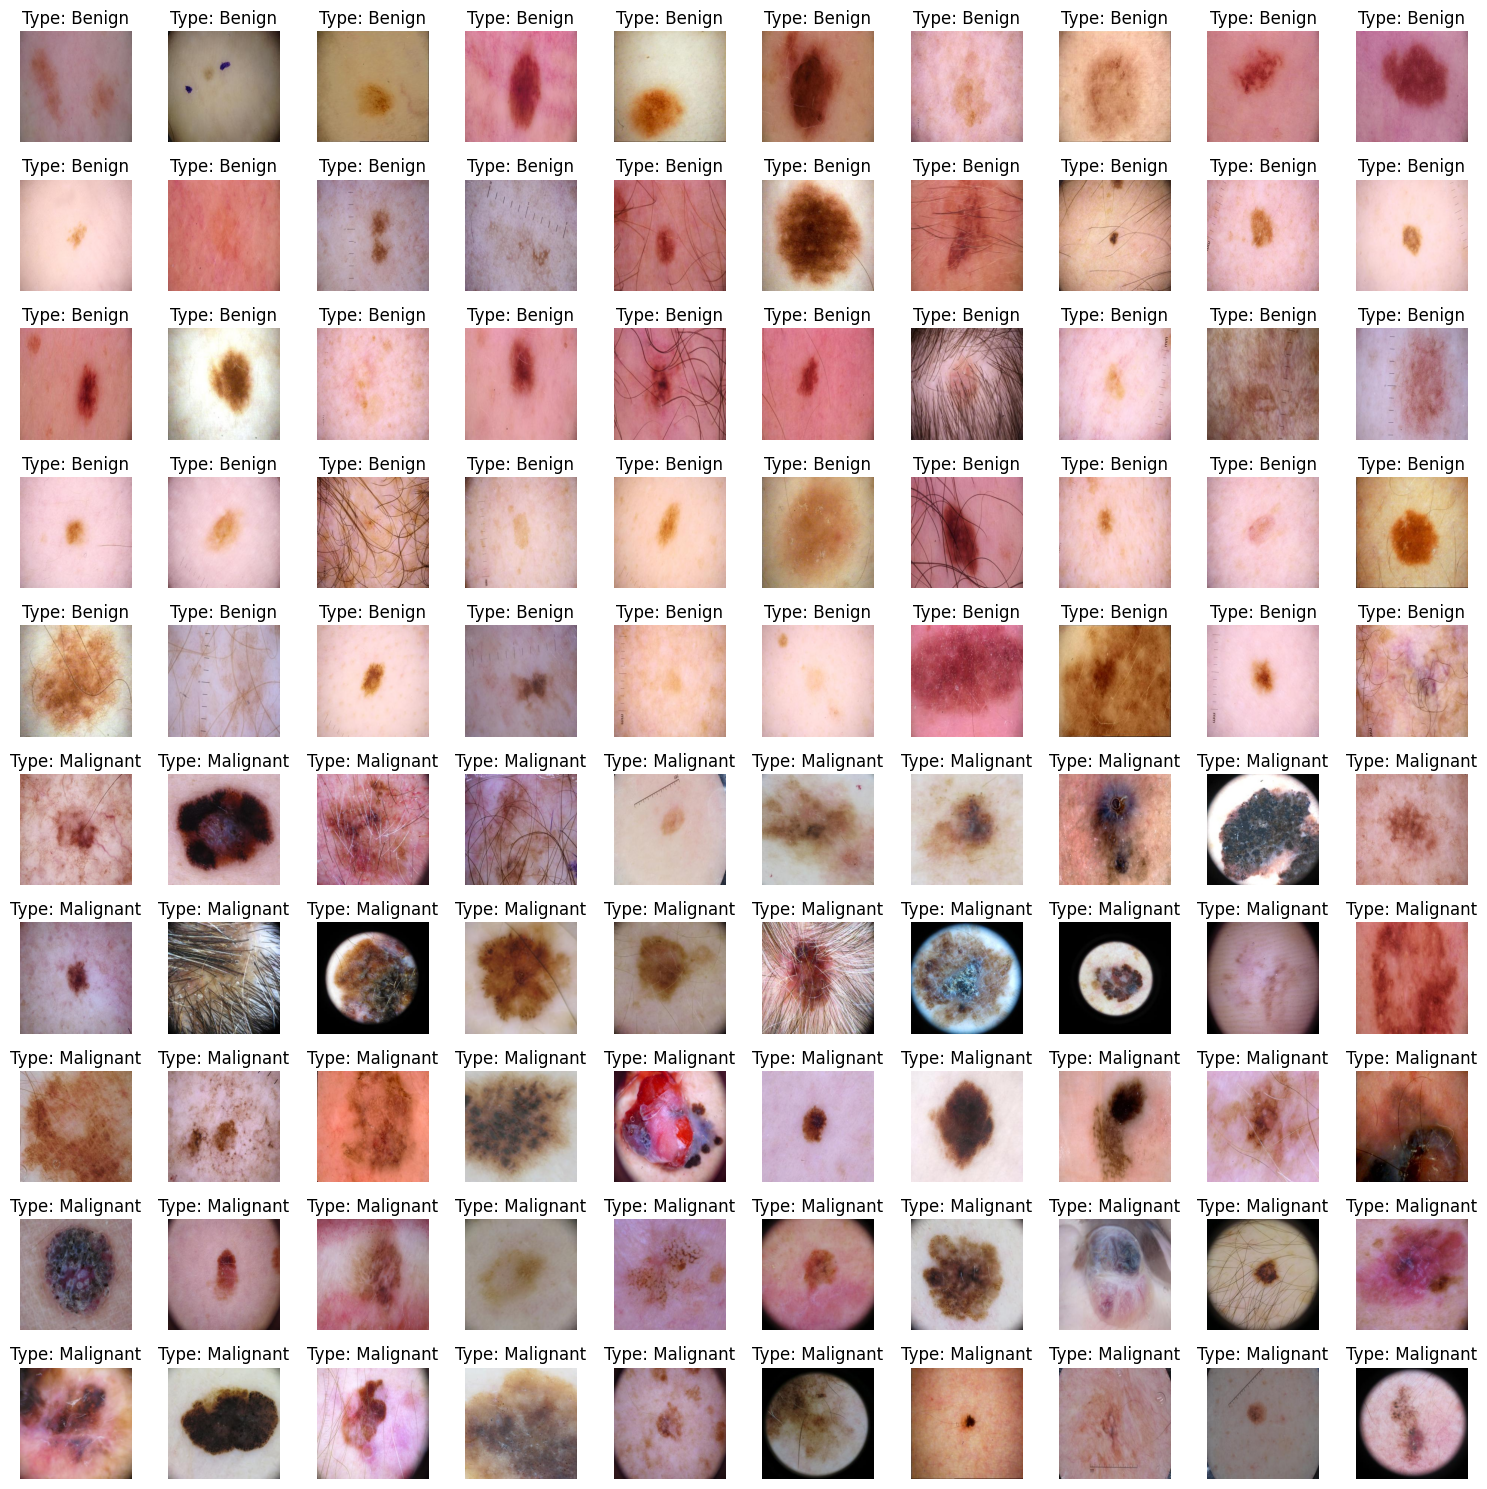

In [20]:
plot_image_grid(sample_df, image_column='Image Path', class_column='Neoplasm Type', grid_size=(10,10))

Type: Benign


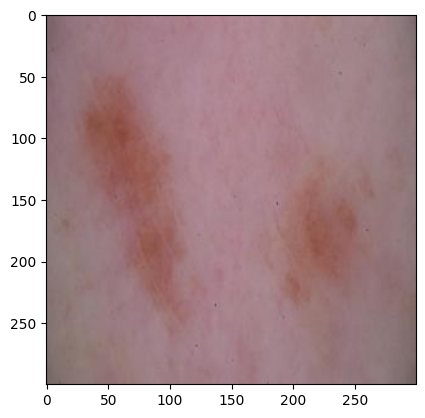

Type: Benign


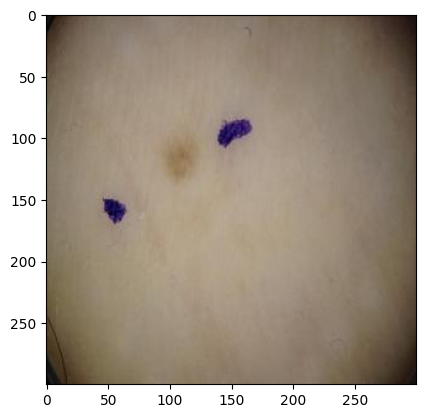

Type: Benign


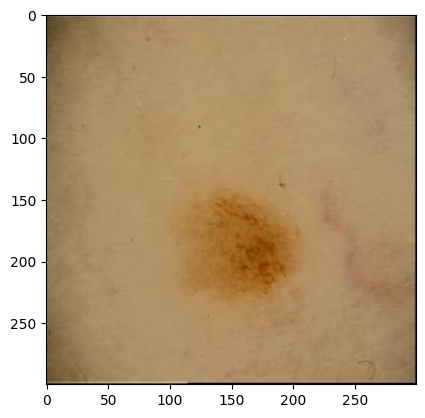

In [21]:
for i, data in enumerate(sample_df.values):
    if i >= 3:
        break

    path, label, target = data
    # # Read and resize the image
    img = cv.imread(path)
    
    if img is None:
        print(f"Error loading image at {path}")
        continue
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
    # Plot the image
    print(f"Type: {label}")
    plt.imshow(img)
    plt.show()

### Class (Benign:Malignant, 0:1) Distribution

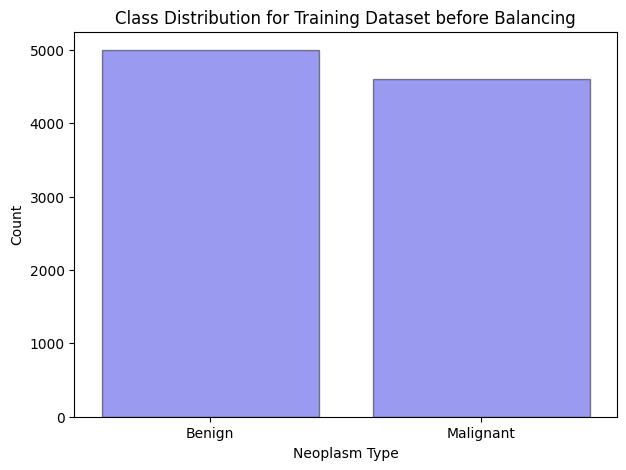

In [22]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train_df, edgecolor='k', color='b', alpha=0.45, x='Neoplasm Type')
plt.title('Class Distribution for Training Dataset before Balancing')
plt.xlabel('Neoplasm Type')
plt.ylabel('Count')
plt.show()

In [23]:
sample_size = len(train_df)

# Calculate the number of unique classes
unique_classes = train_df['Neoplasm Type'].unique()
num_classes = len(unique_classes)
samples_per_class = sample_size // num_classes

# Collect stratified samples
stratified_sample = []
for cls in unique_classes:
    class_sample = train_df[train_df['Neoplasm Type'] == cls].sample(samples_per_class, random_state=42, replace=True)
    stratified_sample.append(class_sample)

# Combine the samples into a single DataFrame
train_df = pd.concat(stratified_sample).reset_index(drop=True)

# Check the distribution of the classes in the sample
print(train_df['Neoplasm Type'].value_counts())

Neoplasm Type
Benign       4802
Malignant    4802
Name: count, dtype: int64


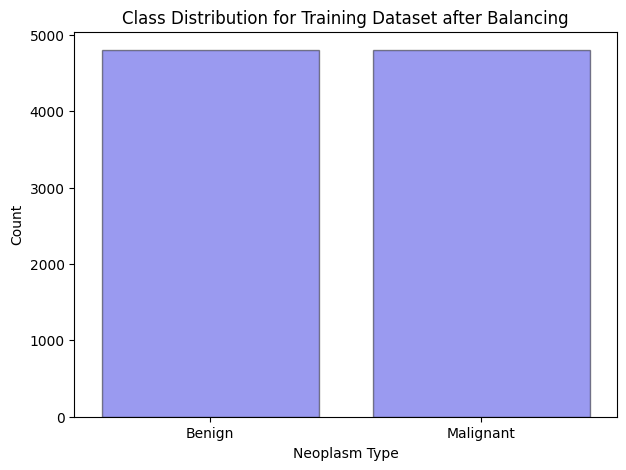

In [24]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train_df, edgecolor='k', color='b', alpha=0.45, x='Neoplasm Type')
plt.title('Class Distribution for Training Dataset after Balancing')
plt.xlabel('Neoplasm Type')
plt.ylabel('Count')
plt.show()

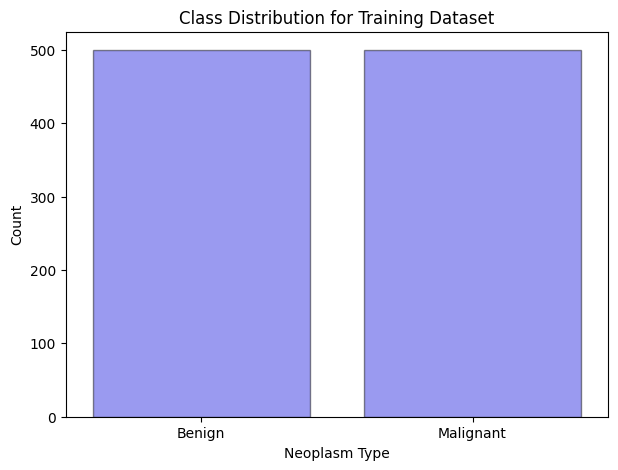

In [25]:
plt.figure(figsize=(7, 5))
sns.countplot(data=test_df, edgecolor='k', color='b', alpha=0.45, x='Neoplasm Type')
plt.title('Class Distribution for Training Dataset')
plt.xlabel('Neoplasm Type')
plt.ylabel('Count')
plt.show()

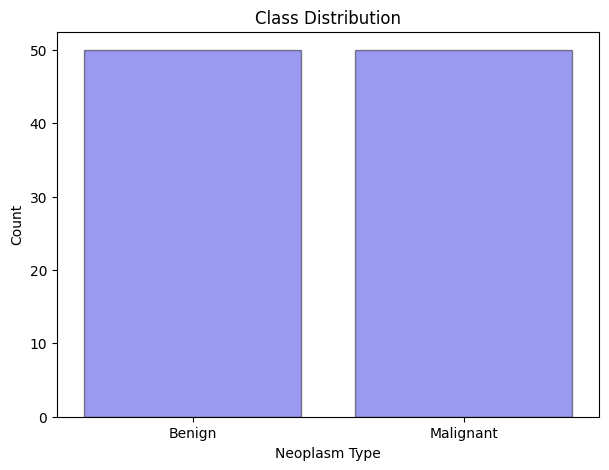

In [26]:
plt.figure(figsize=(7, 5))
sns.countplot(data=sample_df, edgecolor='k', color='b', alpha=0.45, x='Neoplasm Type')
plt.title('Class Distribution')
plt.xlabel('Neoplasm Type')
plt.ylabel('Count')
plt.show()

### Fetch image features and flatten into sample dataframe

In [27]:
sample_df = image_features(sample_df, image_column='Image Path')
display(sample_df)

,Image Path,Neoplasm Type,Target,0,1,2,3,4,5,6,...,269990,269991,269992,269993,269994,269995,269996,269997,269998,269999
0,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0,0.466667,0.376471,0.400000,0.474510,0.384314,0.407843,0.482353,...,0.388235,0.443137,0.388235,0.384314,0.439216,0.384314,0.380392,0.435294,0.380392,0.376471
1,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0,0.062745,0.090196,0.113725,0.043137,0.074510,0.086275,0.058824,...,0.058824,0.086275,0.066667,0.054902,0.078431,0.062745,0.058824,0.074510,0.058824,0.054902
2,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0,0.223529,0.160784,0.109804,0.223529,0.160784,0.109804,0.223529,...,0.000000,0.027451,0.000000,0.000000,0.105882,0.070588,0.043137,0.023529,0.000000,0.000000
3,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0,0.815686,0.478431,0.592157,0.815686,0.478431,0.592157,0.815686,...,0.356863,0.564706,0.352941,0.345098,0.545098,0.345098,0.333333,0.537255,0.337255,0.325490
4,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0,0.521569,0.458824,0.368627,0.517647,0.454902,0.356863,0.529412,...,0.039216,0.168627,0.098039,0.019608,0.168627,0.086275,0.003922,0.168627,0.082353,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
96,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1,0.345098,0.270588,0.203922,0.376471,0.290196,0.207843,0.411765,...,0.000000,0.192157,0.003922,0.000000,0.192157,0.000000,0.000000,0.188235,0.000000,0.000000
97,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1,0.078431,0.086275,0.133333,0.117647,0.133333,0.176471,0.164706,...,0.313725,0.188235,0.231373,0.309804,0.192157,0.223529,0.298039,0.192157,0.223529,0.298039
98,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1,0.054902,0.070588,0.082353,0.062745,0.078431,0.090196,0.066667,...,0.113725,0.094118,0.098039,0.113725,0.094118,0.098039,0.113725,0.090196,0.094118,0.109804


### Pixel Value Distribution

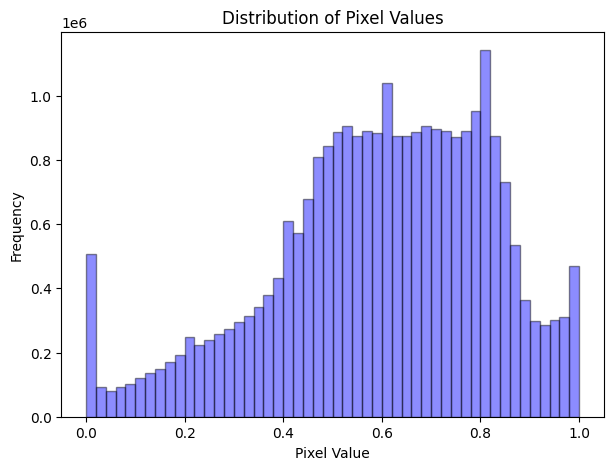

In [28]:
pixel_columns = sample_df.columns[3:]
pixel_values = sample_df[pixel_columns].values

plt.figure(figsize=(7, 5))
plt.hist(pixel_values.flatten(), edgecolor='k', color='b', alpha=0.45, bins=50)
# sns.histplot(pixel_values.flatten(), bins=50, kde=True)
plt.title('Distribution of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

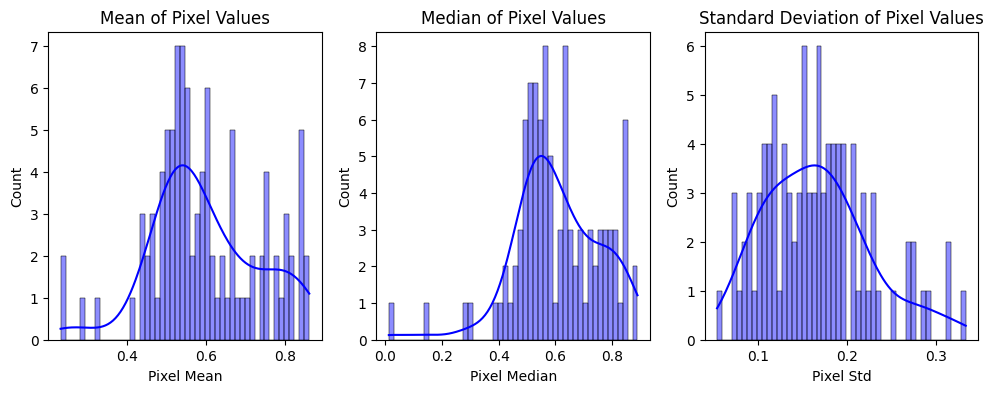

In [29]:
descriptive_stats_df = pd.DataFrame([])
pixel_mean = np.mean(pixel_values, axis=1)
pixel_median = np.median(pixel_values, axis=1)
pixel_std = np.std(pixel_values, axis=1)

descriptive_stats_df['Pixel Mean'] = pixel_mean
descriptive_stats_df['Pixel Median'] = pixel_median
descriptive_stats_df['Pixel Std'] = pixel_std

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(descriptive_stats_df['Pixel Mean'], bins=50, color='b', alpha=0.45, kde=True)
plt.title('Mean of Pixel Values')

plt.subplot(1, 3, 2)
sns.histplot(descriptive_stats_df['Pixel Median'], bins=50, color='b', alpha=0.45, kde=True)
plt.title('Median of Pixel Values')

plt.subplot(1, 3, 3)
sns.histplot(descriptive_stats_df['Pixel Std'], bins=50, color='b', alpha=0.45, kde=True)
plt.title('Standard Deviation of Pixel Values')

plt.show()

### Data Preprocessing and Loading

In [30]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SkinCancerImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with image paths and labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.data_frame.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.data_frame.iloc[idx, 2].reshape()

        if self.transform:
            image = self.transform(image)

        return image, label

In [31]:
# Example usage:
# Define any data augmentations or transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Create datasets from CSV files
train_dataset = SkinCancerImageDataset(csv_file='../data/train.csv', transform=transform)
test_dataset = SkinCancerImageDataset(csv_file='../data/test.csv', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [32]:
# Example iteration through the data loader
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 128, 128]) torch.Size([32])


In [33]:
device = torch.device('cpu')

# macOS Apple Silicon check:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

device

device(type='mps')

In [42]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    correct, train_loss = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device) # saving tensor to device (either cpu or gpu on mac which is called 'mps)
        pred = model(X)
        print(pred.shape, y.shape)
        loss = loss_fn(pred, y)

        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    train_loss /= num_batches    
    correct /= size
    
    print(f"Training Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

    return train_loss, correct


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Saving tensor to device (either cpu or gpu on mac which is called 'mps')
            pred = model(X)
            # print("Bruh", nn.functional.softmax(pred[0]).argmax())
            # print("bruh2", pred[0].argmax())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import torch.nn.functional as F

class NeoplasmClassifier(nn.Module):
    def __init__(self):
        super(NeoplasmClassifier, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # First convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample by a factor of 2

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample by a factor of 2

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample by a factor of 2
        )
        
        self.flatten = nn.Flatten()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64 * 16 * 16, 128),  # Adjusted to match the output of the conv layers
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # One output neuron for binary classification
        )
        
    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [44]:
# 4. Training the Network
model = NeoplasmClassifier().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
epochs = 10
train_cumulative_loss, train_cumulative_acc = [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_loader, model, criterion, optimizer)
    train_cumulative_loss.append(train_loss)
    train_cumulative_acc.append(train_acc)
print(train_cumulative_loss[-1:],
      train_cumulative_acc[-1:])

Epoch 1
-------------------------------
torch.Size([32, 1]) torch.Size([32])


ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')

Accuracy: 50.0%
